In [42]:
import numpy as np
import pylab as plt

from scipy.linalg import sqrtm, solve
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import interp1d
from numpy.polynomial import legendre
import time

import healpy as hp

## Spectral basis functions

In [11]:
def basis_edges_poly(nu, nu_ref=300., params=None):
    """
    Shape (Nfreqs, Nmodes)
    """
    x = nu / nu_ref
    return np.array(
                [ x**-2.5,
                  x**-2.5 * np.log(x),
                  x**-2.5 * np.log(x)**2.,
                  x**-4.5,
                  x**-2.]
        ).T


def basis_powerlaw(nu, nu_ref=300., params=[-2.7,]):
    """
    Shape (Nfreqs, Nmodes)
    """
    x = nu / nu_ref
    beta = params[0]
    return np.array([x**beta,]).T


def basis_poly_legendre(nu, nu_ref=300., params=[5,]):
    """
    Shape (Nfreqs, Nmodes)
    """
    # Generate Legendre functions
    poly_order = params[0]
    lf = legendre(poly_order)
    
    # Normalise freqs. on interval [-1, +1]
    pass

## Sky model projection function

In [60]:
def sky_model(amps, proj_matrix):
    """
    Compute a full sky model given a set of parameters.
    
    Parameters:
        amps (array_like):
            Amplitudes for the basis functions in each pixel. 
            Expected shape: `(Npix, Nmodes)`.
        proj_matrix (array_like):
            Projection operator for each pixel, which goes 
            from parameters to temperature values at each 
            frequency. Shape: `(Nfreqs, Nmodes)`.
    
    Returns:
        sky_model (array_like):
            Array of sky maps at each frequency, of shape `(Nfreqs, Npix)`.
    """
    # Initialise sky model array
    Npix = amps.shape[0]
    Nfreqs = proj_matrix.shape[0]
    sky_map = np.zeros((Nfreqs, Npix))
    
    # Multiply amplitudes by projection operator to get per-freq. maps
    sky_map[:,:] = proj_matrix @ amps.T
    return sky_map

## Sampling functions

In [37]:
def inversion_sample_beta(beta_min, beta_max, grid_points=400, 
                          interp_kind='linear', realisations=1):
    """
    Use inversion sampling to draw samples of the power law beta parameter.
    """
    # Calculate likelihood values as a function of beta
    beta_vals = np.linspace(beta_min, beta_max, grid_points)
    model = model_fn(beta_vals)
    likelihood_fn = np.exp(-0.5 * inv_noise_var * (data - model**2.))
    
    # Calculate CDF
    cdf = cumulative_trapezoid(likelihood_fn, beta_vals, initial=0.)
    cdf /= cdf[-1] # normalise to interval [0, 1]
    
    # Build interpolator
    interp_cdf = interp1d(beta_vals, cdf, kind=interp_kind)
    
    # Draw uniform random sample(s) and map to distribution for beta using CDF
    uvals = np.random.uniform(size=realisations)
    beta_samples = np.array([interp_cdf(u) for u in uvals])
    return beta_samples

In [137]:
def linear_solve_pixel(data, proj_matrix, delta_gains, inv_noise_var, Sinv, realisations=1, comm=None):
    """
    Solve Gaussian Constrained Realisation system for spectral parameters 
    in each pixel.
    
    Parameters:
        data (array_like):
            Healpix maps for each frequency band, of shape `(Nfreqs, Npix)`.
        proj_matrix (array_like):
            Projection operator to go from parameters to a temperature 
            at each frequency. This operator is assumed to be the same 
            for each pixel.
        delta_gains (array_like):
            Fractional gain fluctuation for each band. Has shape `(Nfreqs,)`.
        inv_noise_var (array_like):
            The inverse of the noise variance per frequency channel, per 
            pixel. Expected shape: `(Nfreqs, Npix)`.
        Sinv (array_like):
            Inverse of the prior covariance matrix for the spectral 
            parameters, assumed to be the same for all pixels.
        realisations (int):
            Number of realisations of the GCR solution to return.
        comm (MPI communicator):
            MPI Communicator object.
    
    Returns:
        g (array_like):
            Array of sampled per-frequency gain values. 
            Shape: `(realisations, Nfreqs)`.
    """
    # Set up MPI if enabled
    myid = 0
    nworkers = 1
    if comm is not None:
        myid = comm.Get_rank()
        nworkers = comm.Get_size()
    
    # Get matrix shapes
    Nfreqs, Nmodes = proj_matrix.shape
    Npix = inv_noise_var.shape[1]
    
    # Loop over pixels
    for p in range(Npix):
        
        # MPI worker assignment
        if p % nworkers != myid:
            continue
        
        # LHS matrix: (S^-1 + A^T N^-1 A)
        # proj_matrix has shape (Nfreqs, Nmodes)
        # Sinv has shape (Nmodes, Nmodes)
        # Ninv has shape (Nfreqs, Nfreqs)
        Ninv = np.diag(inv_noise_var[:,p])
        lhs_op = Sinv + proj_matrix.T @ Ninv @ proj_matrix

        # Empty results matrix
        s = np.zeros((realisations, Npix, Nmodes))

        for i in range(realisations):
            # Draw unit Gaussian random numbers
            omega_n = np.random.randn(Nfreqs)
            omega_s = np.random.randn(Nmodes)

            # RHS vector
            # data has shape (Nfreqs,)
            rhs = proj_matrix.T @ Ninv @ data[:,p] \
                + proj_matrix.T @ sqrtm(Ninv) @ omega_n \
                + sqrtm(Sinv) @ omega_s

            # Do linear solve for symmetric matrix
            s[i,p] = solve(lhs_op, rhs, assume_a='sym')
    
    # FIXME: Need to do MPI communication
    total_s = np.zeros_like(s)
    if comm is not None:
        comm.Allreduce(s.flatten(), total_s, op=MPI_SUM)
        total_s = total_s.reshape(s.shape)
    else:
        total_s = s
    
    return total_s


def linear_solve_gain(data, amps, proj_matrix, inv_noise_var, Sinv, realisations=1):
    """
    Solve Gaussian Constrained Realisation system for gain parameters 
    that are common to all pixels at a given frequency (i.e. an overall 
    multiplicative factor per band).
    
    Note that this solves for the gain fractional perturbations, delta g, 
    where we have defined gain = gbar (1 + delta g), and gbar = 1.
    
    Parameters:
        data (array_like):
            Healpix maps for each frequency band, of shape `(Nfreqs, Npix)`.
        amps (array_like):
            Amplitudes for the spectral basis functions in each pixel. 
            Expected shape: `(Npix, Nmodes)`.
        proj_matrix (array_like):
            Projection operator to go from parameters to a temperature 
            at each frequency. This operator is assumed to be the same 
            for each pixel.
        inv_noise_var (array_like):
            The inverse of the noise variance per frequency channel, per 
            pixel. Expected shape: `(Nfreqs, Npix)`.
        Sinv (array_like):
            Inverse of the prior covariance matrix for the per-frequency 
            channel gains.
        realisations (int):
            Number of realisations of the GCR solution to return.
    
    Returns:
        g (array_like):
            Array of sampled per-frequency gain values. 
            Shape: `(realisations, Nfreqs)`.
    """
    Nfreqs, Npix = data.shape
    
    # Get sky model
    model = sky_model(amps, proj_matrix) # (Nfreqs, Npix)
    
    # Construct LHS matrix. The gains are per-band and the noise covariance 
    # is assumed to be diagonal, so the A^T N^-1 A term is diagonal in frequency
    lhs_op = Sinv + np.diag( np.sum(inv_noise_var * model**2., axis=1) )
    
    # Empty results matrix
    g = np.zeros((realisations, Nfreqs))
    
    # Loop over requested realisations
    for i in range(realisations):
        # Draw unit Gaussian random numbers
        omega_n = np.random.randn(*model.shape) # same size as data!
        omega_g = np.random.randn(Nfreqs)

        # RHS vector
        # This works with the residual, as we model the data as:
        # data = gbar (1 + delta g) sky_model and gbar = 1
        # So: resid = data - sky_model = delta_g sky_model
        rhs = np.sum(
                     model * (inv_noise_var * (data - model)
                              + np.sqrt(inv_noise_var) * omega_n),
                     axis=1
                    ) \
            + sqrtm(Sinv) @ omega_g

        # Do linear solve for symmetric matrix
        g[i] = solve(lhs_op, rhs, assume_a='sym')
        
    return g

Solve took  0.2027 sec


Text(0.5, 0, 'Freqs')

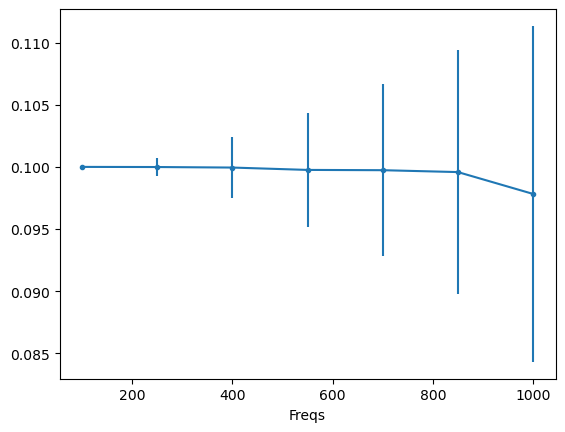

In [129]:
# Make random maps
Npix = hp.nside2npix(8)
amps = np.ones((Npix, proj.shape[1])) # (Npix, Nmodes)
amps += 0.05 * np.random.randn(*amps.shape)

random_maps = 1.1 * sky_model(amps, proj)

inv_noise_var = np.ones_like(random_maps) / (0.1)**2.
Sginv = np.eye(freqs.size) / (0.1**2.)

t0 = time.time()
g = linear_solve_gain(data=random_maps, 
                      amps=amps, 
                      proj_matrix=proj, 
                      inv_noise_var=inv_noise_var, 
                      Sinv=Sginv, 
                      realisations=1000)
print("Solve took %7.4f sec" % (time.time() - t0))

plt.errorbar(freqs, np.mean(g, axis=0), yerr=np.std(g, axis=0), marker='.')
plt.xlabel("Freqs")

(7, 5)
Solve took  0.1706 sec


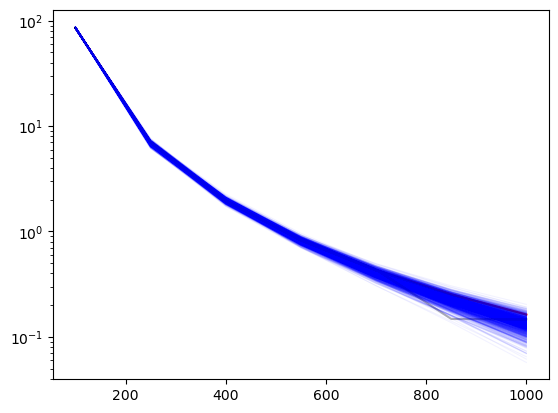

In [119]:
freqs = np.linspace(100., 1000., 7)

# Generate simple test data with noise
model = 4.3 * (freqs / 300.)**-2.72 # Kelvin
std = 0.2 * (freqs / 300.)**-1.4
Ninv = np.diag(1./std**2.)
n = std * np.random.randn(freqs.size)
d = model + n

# Projection operator for chosen spectral basis
proj = basis_edges_poly(freqs)
print(proj.shape)
Nmodes = proj.shape[1]

# Prior covariance
Sinv = np.eye(Nmodes)

# Do linear solve
t0 = time.time()
s = linear_solve_pixel(data=d, proj_matrix=proj, Ninv=Ninv, Sinv=Sinv, realisations=1000)
print("Solve took %7.4f sec" % (time.time() - t0))

# Reconstruct solved model
m_sample = np.array([proj @ s[i] for i in range(s.shape[0])])

# Plot results
plt.subplot(111)
plt.plot(freqs, d, color='k', alpha=0.3)
plt.plot(freqs, model, 'r-', lw=1.5)
plt.plot(freqs, m_sample.T, 'b-', lw=0.8, alpha=0.05)
plt.yscale('log')

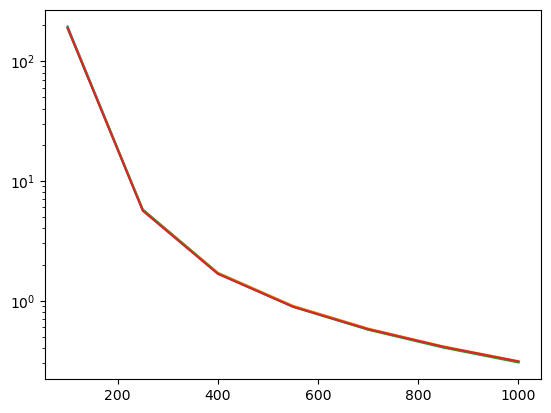

In [130]:
plt.plot(freqs, random_maps[:,0])
plt.plot(freqs, random_maps[:,3])
plt.plot(freqs, random_maps[:,8])
plt.plot(freqs, random_maps[:,10])
plt.yscale('log')

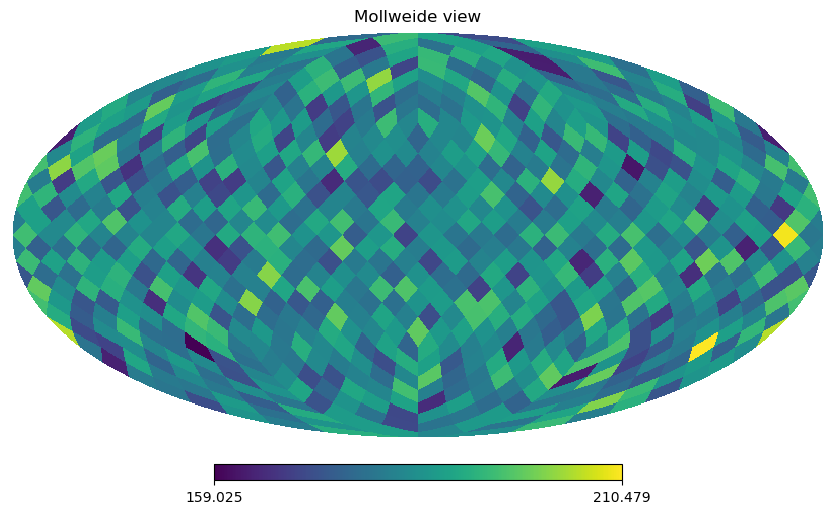

In [131]:
hp.mollview(random_maps[0])